### Project Title : - Using Lung ultrasound images for building a reliable Point-of-care Covid-19 testing system

#### Multi Classifier : For classifying lung ultrasound images into one of the categories : Covid, Normal, Pneumonia and Other

In [ ]:
#Mounting the google drive as the data is available there

from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


#### Loading and pre-processing of the image dataset

In [ ]:
#Importing the libraries
import pathlib
from pathlib import Path
from tensorflow.keras.preprocessing.image import load_img, img_to_array, smart_resize
import numpy as np

p = Path().cwd()
q = p/'drive'/'My Drive'/'My_Dataset' # use p to create a path to the data 


#There are four classes our classes
target_dict = {"Normal" : 0, "covid" :1, "Pneumonia" : 2, "Other" : 3 }
images = [] # create an empty list
labels = [] # create an empty list  

#This piece of code loads the images, resize them to 197X198 pixels and append them to a list

#Label for every image is appended to the list as well

for fldr in q.iterdir(): 
    current_label = fldr.name # get the name of the current label 
    print(current_label)  
    for img in fldr.iterdir():
        img = load_img(img,grayscale = True)
        img_array = img_to_array(img) # convert the image to an NumPy array 
        size = (197,198)
        img_array_resized = smart_resize(img_array,size)
        images.append(img_array_resized)# add reshaped image to list of images 
        labels.append(current_label)# add label for this image to the list of labels 
        



covid


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Normal
Other
Pneumonia


In [ ]:
images_1 = np.array(images) # convert the list of images to a NumPy array 
labels_1 = np.array(labels) # convert the list of labels to a NumPy array

In [ ]:
# use the target_dict to convert the string labels to an array of integers

labels_1 = np.asarray(list(map(lambda x: target_dict[x] if x in target_dict.keys() else x , labels_1))) 

In [ ]:
#normalizing the images by making sure that the pixel values lie between 0 and 1

images_1 = images_1/255.0

In [ ]:
#sklearn expects i/p to be 2d array-model.fit(x_train,y_train)=>reshape to 2d array

nsamples, nx, ny, nrgb = images_1.shape
images_1 = images_1.reshape((nsamples,nx*ny*nrgb))

#### Splitting the dataset

In [ ]:
from sklearn.model_selection import train_test_split


#Splitting data into training,testing and validation
X_train, X_test, y_train, y_test = train_test_split(images_1, labels_1, test_size=0.3, random_state=111)

#### Balanced Bagging Classifier with Decision Tree Classifier

In [ ]:
!pip install scikit-learn==1.0 -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import imblearn
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier

#Create an instance 

#Balanced Bagging classifier, resamples the training data while fitting a model on it using a resampling strategy

#Here, we are resampling all classes except the majority so that all classes have comparable number of instances
classifier = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='not majority',
                                replacement=False,
                                random_state=42)


In [ ]:
#Fitting the classifier on the training data 
classifier.fit(X_train, y_train)

BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                          random_state=42, sampling_strategy='not majority')

#### Testing model's performance

In [ ]:
#Making predictions on the test data
preds = classifier.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score,recall_score, f1_score

# calculate accuracy, precision, recall and F1_score for evaluating the model's performance
accuracy = accuracy_score(y_test, preds)
print('Model accuracy is: ', accuracy)

#'weighted' average is being used as it is a multi-classification problem and each performance measure will be an average of the same metric for all classes but with weights assigned to them.

precision = precision_score(y_test, preds, average = 'weighted')
print('Model precision is: ', precision)

recall = recall_score(y_test, preds, average = 'weighted')
print('Model recall is: ', recall)

f1_score = f1_score(y_test, preds, average = 'weighted')
print('Model F1-Score is: ', f1_score)



Model accuracy is:  0.9537754114230397
Model precision is:  0.9535835304552484
Model recall is:  0.9537754114230397
Model F1-Score is:  0.9534967891936419


In [ ]:
#Printing the classification report to get a picture of performance on all classes

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

print(classification_report(preds,y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       460
           1       1.00      1.00      1.00      1177
           2       0.87      0.91      0.89       833
           3       0.95      0.93      0.94      1662

    accuracy                           0.95      4132
   macro avg       0.96      0.96      0.96      4132
weighted avg       0.95      0.95      0.95      4132



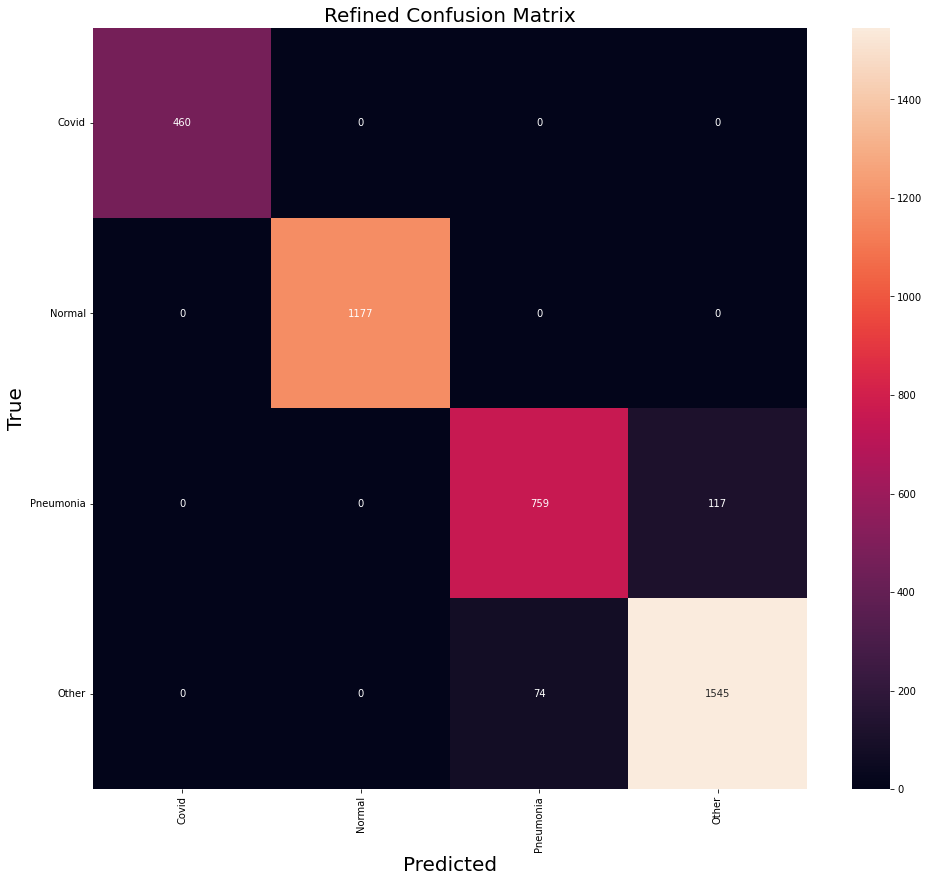

In [ ]:
# Plot confusion matrix in a beautiful manner
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, preds)

class_names = ['Covid','Normal','Pneumonia','Other']
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Refined Confusion Matrix', fontsize=20)
plt.show()

#### Multinomial Logistic Regression with Stratification

In [ ]:
from sklearn.model_selection import train_test_split


#Splitting data into training,testing and validation

#Stratification ensures that the proportion of instances in training and test dataset for each class should be same as that of the original dataset.

X_train, X_test, y_train, y_test = train_test_split(images_1, labels_1, test_size=0.3, random_state=111, stratify = labels_1)

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# fit the model on the whole dataset

model.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(multi_class='multinomial')

#### Testing model's performance

In [ ]:
#Getting predictions on the test data

preds = model.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score,recall_score, f1_score

# calculating the performance measures

accuracy = accuracy_score(y_test, preds)
print('Model accuracy is: ', accuracy)

precision = precision_score(y_test, preds, average = 'weighted')
print('Model precision is: ', precision)

recall = recall_score(y_test, preds, average = 'weighted')
print('Model recall is: ', recall)

f1_score = f1_score(y_test, preds, average = 'weighted')
print('Model F1-Score is: ', f1_score)

Model accuracy is:  0.9542594385285575
Model precision is:  0.9542991903908122
Model recall is:  0.9542594385285575
Model F1-Score is:  0.9542789757177947


In [ ]:
#Printing the classification report to get a picture of performance on all classes

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

print(classification_report(preds,y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       482
           1       1.00      1.00      1.00      1198
           2       0.89      0.89      0.89       852
           3       0.94      0.94      0.94      1600

    accuracy                           0.95      4132
   macro avg       0.96      0.96      0.96      4132
weighted avg       0.95      0.95      0.95      4132



In [ ]:
# Creating  a confusion matrix,which compares the y_test and y_pred
cm = confusion_matrix(y_test, preds)

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = ['Covid','Normal','Pneumonia','Other'], 
                     columns = ['Covid','Normal','Pneumonia','Other'])

print(cm_df)

           Covid  Normal  Pneumonia  Other
Covid        482       0          0      0
Normal         0    1198          0      1
Pneumonia      0       0        757     93
Other          0       0         95   1506


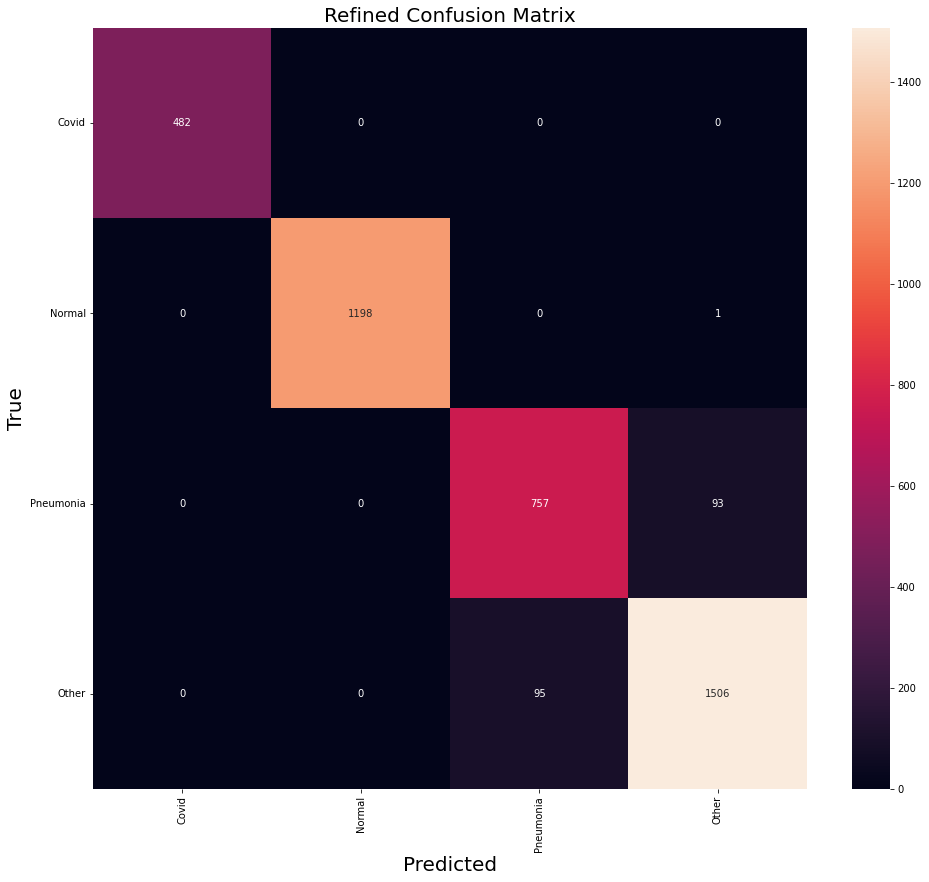

In [ ]:
# Plot confusion matrix in a beautiful manner

cm = confusion_matrix(y_test, preds)

class_names = ['Covid','Normal','Pneumonia','Other']
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Refined Confusion Matrix', fontsize=20)
plt.show()